memory usage in kB: [539.0, 588.0, 1372.0, 517.6, 514.5, 172.3, 172.3, 171.5, 85.9, 85.9, 85.9, 91.9, 128.8, 128.8, 128.6, 53.6, 53.6, 61.2]


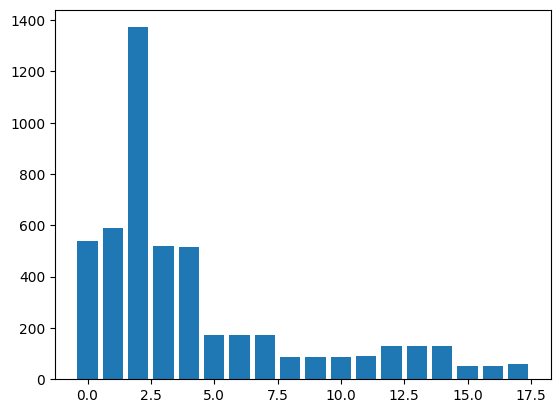

In [16]:
import torch
import torch.nn as nn
import numpy as np
import torchvision

DATA_TYPE = 'int8'
INPLACE_DW = True

assert DATA_TYPE in ['int8']


def record_in_out_size(m, x, y):
    x = x[0]
    m.input_shape = list(x.shape)
    m.output_shape = list(y.shape)
    # we discard the batch dimension for now
    m.input_size = np.prod(m.input_shape[1:]).item()
    m.output_size = np.prod(m.output_shape[1:]).item()


def add_io_hooks(m_):
    # let's register the hook for all
    m_.register_forward_hook(record_in_out_size)


def estimate_conv(m):
    assert isinstance(m, nn.Conv2d), type(m)
    if INPLACE_DW and m.in_channels == m.out_channels == m.groups:  # inplace depthwise from MCUNetV1
        return m.input_size + np.prod(m.output_shape[2:])  # add a buffer with size equal to one channel
    else:  # normal conv
        return m.input_size + m.output_size


def estimate_mbconv(m):
    assert len(m.conv) in [3, 4]
    if DATA_TYPE == 'int8':  # normal implementation for int8 quantized case
        if m.use_res_connect:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1]),
                ])
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1][0]) + m.input_size,
                    estimate_conv(m.conv[2])
                ])
        else:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1])
                ])
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1][0]),
                    estimate_conv(m.conv[2])
                ])
    else:
        raise NotImplementedError


def nelem2kb(n):
    # converting number of elements to kB according to the precision
    if DATA_TYPE == 'fp':
        n = n * 4  # 4 bytes per floating point
    return n / 1024


def estimate_model(model, x):
    model.eval()
    model.apply(add_io_hooks)

    with torch.no_grad():
        _ = model(x)

    memory_usage = list()

    # now estimate the memory of the backbone
    # first conv
    memory_usage.append(estimate_conv(model.features[0][0]))
    # blocks
    for b in model.features[1:-1]:
        memory_usage.append(estimate_mbconv(b))

    # now convert everything into kB
    memory_usage = [nelem2kb(m) for m in memory_usage]

    print('memory usage in kB:', [round(m, 1) for m in memory_usage])  # kB

    import matplotlib.pyplot as plt
    plt.bar(range(len(memory_usage)), memory_usage)
    plt.show()


if __name__ == '__main__':
    net = torchvision.models.mobilenet_v2()
    sample_input = torch.randn(1, 3, 224, 224)
    estimate_model(net, sample_input)

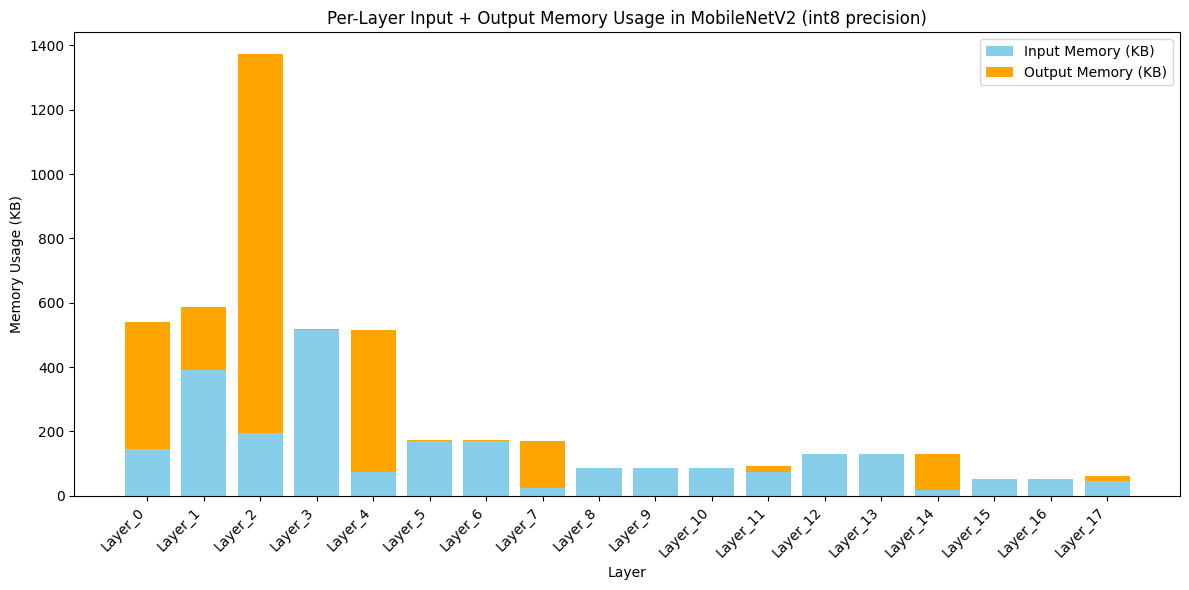

In [17]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# Set the data type and properties
DATA_TYPE = 'int8'
INPLACE_DW = True

assert DATA_TYPE in ['int8']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Discard batch dimension
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Estimate memory usage for a Conv2D layer
def estimate_conv(m):
    assert isinstance(m, nn.Conv2d), type(m)
    if INPLACE_DW and m.in_channels == m.out_channels == m.groups:  # inplace depthwise from MCUNetV1
        return m.input_size, np.prod(m.output_shape[2:])  # Separate input and output memory
    else:  # Normal conv
        return m.input_size, m.output_size

# Estimate memory usage for MobileNetV2's MBConv blocks
def estimate_mbconv(m):
    assert len(m.conv) in [3, 4]
    if DATA_TYPE == 'int8':  # Normal implementation for int8 quantized case
        if m.use_res_connect:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1]),
                ], key=lambda x: sum(x))  # Max of input+output sum
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    (estimate_conv(m.conv[1][0])[0] + m.input_size, estimate_conv(m.conv[1][0])[1]),
                    estimate_conv(m.conv[2])
                ], key=lambda x: sum(x))
        else:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1])
                ], key=lambda x: sum(x))
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1][0]),
                    estimate_conv(m.conv[2])
                ], key=lambda x: sum(x))
    else:
        raise NotImplementedError

# Convert number of elements to kilobytes (KB)
def nelem2kb(n, data_type=DATA_TYPE):
    # Convert number of elements to memory size in kB according to the data type
    element_size = 1 if data_type == 'int8' else 4  # 1 byte for int8, 4 bytes for float32
    return n * element_size / 1024

# Main function to estimate per-layer memory for MobileNetV2 and generate combined figure
def estimate_model(model, x):
    model.eval()
    model.apply(add_io_hooks)

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []

    # Now estimate the memory of the backbone
    # First conv layer
    in_mem, out_mem = estimate_conv(model.features[0][0])
    memory_input.append(in_mem)
    memory_output.append(out_mem)

    # Blocks
    for b in model.features[1:-1]:
        in_mem, out_mem = estimate_mbconv(b)
        memory_input.append(in_mem)
        memory_output.append(out_mem)

    # Convert everything into kB
    memory_input_kb = [nelem2kb(m) for m in memory_input]
    memory_output_kb = [nelem2kb(m) for m in memory_output]

    # Plotting the combined figure
    plt.figure(figsize=(12, 6))
    layer_indices = range(len(memory_input_kb))

    # Create a stacked bar chart for Input and Output memory
    plt.bar(layer_indices, memory_input_kb, color='skyblue', label='Input Memory (KB)')
    plt.bar(layer_indices, memory_output_kb, bottom=memory_input_kb, color='orange', label='Output Memory (KB)')
    plt.xticks(layer_indices, [f'Layer_{i}' for i in layer_indices], rotation=45, ha='right')
    plt.xlabel("Layer")
    plt.ylabel("Memory Usage (KB)")
    plt.title(f"Per-Layer Input + Output Memory Usage in MobileNetV2 ({DATA_TYPE} precision)")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    net = torchvision.models.mobilenet_v2()
    sample_input = torch.randn(1, 3, 224, 224)
    estimate_model(net, sample_input)


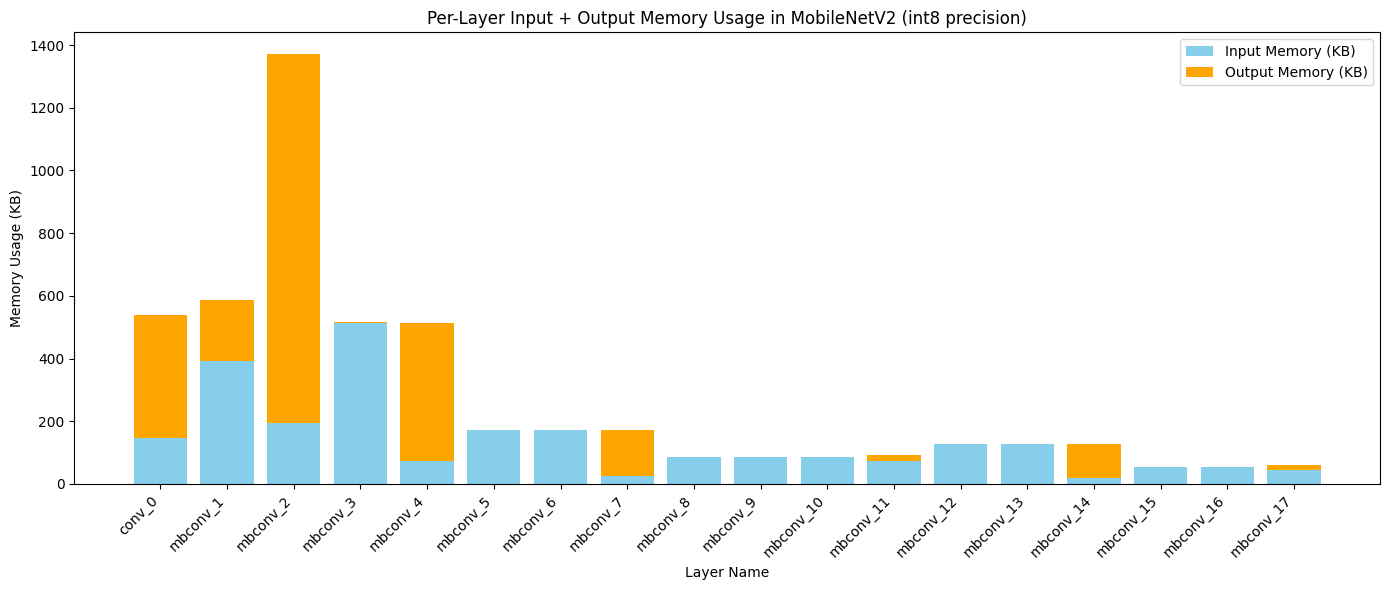

In [18]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt

# Set the data type and properties
DATA_TYPE = 'int8'
INPLACE_DW = True

assert DATA_TYPE in ['int8']

# Function to record input and output size of each layer
def record_in_out_size(m, x, y):
    x = x[0]  # Discard batch dimension
    m.input_shape = list(x.shape)  # Store input shape
    m.output_shape = list(y.shape)  # Store output shape
    m.input_size = np.prod(m.input_shape[1:]).item()  # Number of elements in input (excluding batch)
    m.output_size = np.prod(m.output_shape[1:]).item()  # Number of elements in output (excluding batch)

# Function to add hooks to all layers
def add_io_hooks(m_):
    m_.register_forward_hook(record_in_out_size)  # Register forward hook to store input and output sizes

# Estimate memory usage for a Conv2D layer
def estimate_conv(m):
    assert isinstance(m, nn.Conv2d), type(m)
    if INPLACE_DW and m.in_channels == m.out_channels == m.groups:  # inplace depthwise from MCUNetV1
        return m.input_size, np.prod(m.output_shape[2:])  # Separate input and output memory
    else:  # Normal conv
        return m.input_size, m.output_size

# Estimate memory usage for MobileNetV2's MBConv blocks
def estimate_mbconv(m):
    assert len(m.conv) in [3, 4]
    if DATA_TYPE == 'int8':  # Normal implementation for int8 quantized case
        if m.use_res_connect:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1]),
                ], key=lambda x: sum(x))  # Max of input+output sum
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    (estimate_conv(m.conv[1][0])[0] + m.input_size, estimate_conv(m.conv[1][0])[1]),
                    estimate_conv(m.conv[2])
                ], key=lambda x: sum(x))
        else:
            if len(m.conv) == 3:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1])
                ], key=lambda x: sum(x))
            else:
                return max([
                    estimate_conv(m.conv[0][0]),
                    estimate_conv(m.conv[1][0]),
                    estimate_conv(m.conv[2])
                ], key=lambda x: sum(x))
    else:
        raise NotImplementedError

# Convert number of elements to kilobytes (KB)
def nelem2kb(n, data_type=DATA_TYPE):
    # Convert number of elements to memory size in kB according to the data type
    element_size = 1 if data_type == 'int8' else 4  # 1 byte for int8, 4 bytes for float32
    return n * element_size / 1024

# Main function to estimate per-layer memory for MobileNetV2 and generate combined figure
def estimate_model(model, x):
    model.eval()
    model.apply(add_io_hooks)

    with torch.no_grad():
        _ = model(x)  # Perform a forward pass to collect input/output sizes

    memory_input = []
    memory_output = []
    layer_names = []

    # First conv layer
    in_mem, out_mem = estimate_conv(model.features[0][0])
    memory_input.append(in_mem)
    memory_output.append(out_mem)
    layer_names.append(f'conv_0')  # Naming for the first layer

    # Blocks
    block_index = 1  # Start from 1 for naming
    for b in model.features[1:-1]:
        in_mem, out_mem = estimate_mbconv(b)
        memory_input.append(in_mem)
        memory_output.append(out_mem)
        layer_names.append(f'mbconv_{block_index}')  # Naming each MBConv block uniquely
        block_index += 1

    # Convert everything into kB
    memory_input_kb = [nelem2kb(m) for m in memory_input]
    memory_output_kb = [nelem2kb(m) for m in memory_output]

    # Plotting the combined figure
    plt.figure(figsize=(14, 6))
    layer_indices = range(len(memory_input_kb))

    # Create a stacked bar chart for Input and Output memory
    plt.bar(layer_indices, memory_input_kb, color='skyblue', label='Input Memory (KB)')
    plt.bar(layer_indices, memory_output_kb, bottom=memory_input_kb, color='orange', label='Output Memory (KB)')
    plt.xticks(layer_indices, layer_names, rotation=45, ha='right')
    plt.xlabel("Layer Name")
    plt.ylabel("Memory Usage (KB)")
    plt.title(f"Per-Layer Input + Output Memory Usage in MobileNetV2 ({DATA_TYPE} precision)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the function for MobileNetV2
if __name__ == '__main__':
    net = torchvision.models.mobilenet_v2()
    sample_input = torch.randn(1, 3, 224, 224)  # Create a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
    estimate_model(net, sample_input)
